# Frame to Phoneme Classifier
Model network 2, includes:
*    Pre-trained Phoneme Shallow Detectors (38)
*    Pre-trained Specialized Task Classifiers (10)

Combines these models into a final linear layer, and outputs phoneme probabilities



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
drivepath = '/content/gdrive/MyDrive/Spring_2021/11785_Intro_to_Deep_Learning/DL_Group_Project'
specialized_models_path = f'{drivepath}/experiments/specialized_detectors/models'
phoneme_models_path = f'{drivepath}/experiments/phoneme_detectors/'
datapath = '/content/gdrive/MyDrive/Spring_2021/11785_Intro_to_Deep_Learning/dl-group-project-code/preprocessed_data'
drivepath_final = f'{drivepath}/experiments/complete_network_2/'

In [3]:
!pip install tqdm

In [53]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd

In [54]:
NUM_EPOCHS = 100
BATCH_SIZE = 64
HIDDEN_SIZE_shallow = 128
HIDDEN_SIZE_spec = 128
MODEL_VERSION = 1
LEARNING_RATE = 0.01
OTHER_PHONEMES_PERCENT = 0.1

In [55]:
cuda = torch.cuda.is_available()
num_workers = 8 if cuda else 0
DEVICE = "cuda" if cuda else "cpu"
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))

Cuda = True with num_workers = 8


In [85]:
class PhonemesDataset(Dataset):
    
    def __init__(self, basepath, mode):
      phoneme_features = np.zeros((1, 40))  # eliminate this row
      phoneme_labels = np.zeros((1))  # eliminate this row

      with os.scandir(basepath) as entries:
        for entry in entries:
          if entry.is_file():
            if "features" in entry.name and mode in entry.name:
              phoneme_tag = entry.name.split("_")[0]

              features_filepath = entry.path
              labels_filepath = f"{basepath}/{phoneme_tag}_{mode}_labels.npy"

              other_phoneme_features = np.load(features_filepath, allow_pickle=True)
              other_phoneme_labels = np.load(labels_filepath, allow_pickle=True)
              
              # stack to phoneme features
              phoneme_features = np.concatenate((phoneme_features, other_phoneme_features))
              phoneme_labels = np.concatenate((phoneme_labels, other_phoneme_labels))
              
      self.X = phoneme_features[1:]
      self.Y = phoneme_labels[1:]

    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, index):
        x = torch.Tensor(self.X[index]).float()
        y = torch.as_tensor(self.Y[index]).long()
    
        return x,y

    def get_phoneme_label_frames(self, phoneme_label):
        phoneme_indexes = np.where(self.Y == phoneme_label)
        return torch.Tensor(self.X[phoneme_indexes]).float(), torch.as_tensor(self.Y[phoneme_indexes]).long()

In [86]:
def make_dataloader(dataset, train, batch_size):
  if train:
    shuffle = True
    drop_last = True
  else:
    shuffle = False
    drop_last = False
    
  loader = DataLoader(dataset=dataset, batch_size=batch_size,
                      drop_last=drop_last, shuffle=shuffle,
                      pin_memory=True, num_workers=8)
  
  return loader

In [87]:
class PhonemeShallowDetector(nn.Module):
  
  def __init__(self, hidden_size, activation):
    super(PhonemeShallowDetector, self).__init__()
    
    self.linear_layer = nn.Linear(in_features=40, out_features=hidden_size)
    self.bn_layer = nn.BatchNorm1d(num_features=hidden_size)
    self.activation = activation
    self.output_layer = nn.Linear(in_features=hidden_size, out_features=1)
    self.sigmoid = nn.Sigmoid()
    seq_params = [
      self.linear_layer,
      self.bn_layer,
      self.activation,
      self.output_layer,
      self.sigmoid
    ]

    self.network = nn.Sequential(*seq_params)
    
  def forward(self, x):
    return self.network(x)

In [88]:
class SpecializedShallowDetector(nn.Module):
  
  def __init__(self, hidden_size, activation):
    super(SpecializedShallowDetector, self).__init__()
    
    self.linear_layer = nn.Linear(in_features=40, out_features=hidden_size)
    self.bn_layer = nn.BatchNorm1d(num_features=hidden_size)
    self.activation = activation
    self.output_layer = nn.Linear(in_features=hidden_size, out_features=1)
    self.sigmoid = nn.Sigmoid()
    seq_params = [
      self.linear_layer,
      self.bn_layer,
      self.activation,
      self.output_layer,
      self.sigmoid
    ]

    self.network = nn.Sequential(*seq_params)
    
  def forward(self, x):
    return self.network(x)

In [619]:
class FramePhonemeClassifierModel(nn.Module):
  
  def __init__(self, phoneme_mapper, specialized_mapper):
    super(FramePhonemeClassifierModel, self).__init__()
    
    self.phoneme_mapper = phoneme_mapper
    self.specialized_mapper = specialized_mapper

    # generate the SpecializedShallowDetector 
    specialized_detectors = []
    for spec_idx, spec_type in enumerate(self.specialized_mapper):
      specialized_detector = SpecializedShallowDetector(hidden_size=HIDDEN_SIZE_spec, 
                                                        activation=nn.LeakyReLU()).to(DEVICE)
      specialized_detectors.append(specialized_detector)

    self.specialized_detectors = nn.ModuleList(specialized_detectors)

    # generate the PhonemeShallowDetectors 
    phoneme_detectors = []
    for phoneme_index, phoneme_tag in phoneme_mapper.items():
      phoneme_detector = PhonemeShallowDetector(hidden_size=HIDDEN_SIZE_shallow, 
                                                activation=nn.LeakyReLU())
      phoneme_detectors.append(phoneme_detector)

    self.phoneme_detectors = nn.ModuleList(phoneme_detectors)

    self.linear_layer = nn.Linear(in_features=len(phoneme_mapper)+len(specialized_mapper), 
                                  out_features=len(phoneme_mapper))

    self.initialize_specialized_detectors()
    self.initialize_shallow_detectors()

  def initialize_shallow_detectors(self):
    # load weights from shallow detectors pre-trained models
    for phoneme_index, phoneme_tag in self.phoneme_mapper.items():
      phoneme_shallow_detector = self.phoneme_detectors[phoneme_index]

      phoneme_model_path = f"{phoneme_models_path}/model_{phoneme_tag}_{MODEL_VERSION}_99"
      temp = torch.load(phoneme_model_path)
      phoneme_shallow_detector.load_state_dict(temp['model_state_dict'])
      initialized_shallow.append(temp['model_state_dict'])
  
  def initialize_specialized_detectors(self):
    # load weights from shallow detectors pre-trained models
     for spec_idx, spec_type in enumerate(self.specialized_mapper):
      specialized_detector = self.specialized_detectors[spec_idx]

      spec_model_path = f"{specialized_models_path}/model_{spec_type}_{MODEL_VERSION}_29"
      temp = torch.load(spec_model_path)
      specialized_detector.load_state_dict(temp['model_state_dict'])
      initialized_specialized.append(temp['model_state_dict'])
  
  def forward(self, x):
    """
    Returns tuple:
      final outputs (B, NUM_PHONEMES) and shallow classifier outputs (B, NUM_SHALLOW_DETECTORS)
    """
    shallow_classifier_outputs = []
    for phoneme_index, phoneme_tag in self.phoneme_mapper.items():
      phoneme_shallow_detector = self.phoneme_detectors[phoneme_index]
      # run frame through shallow detector
      output = phoneme_shallow_detector(x)
      shallow_classifier_outputs.append(output.reshape(-1))
    
    for spec_idx, spec_type in enumerate(self.specialized_mapper):
      # go through specialized
      specialized_detector = self.specialized_detectors[spec_idx]
      output = specialized_detector(x)
      shallow_classifier_outputs.append(output.reshape(-1))

    # convert to torch tensor
    shallow_classifier_outputs = torch.vstack(shallow_classifier_outputs).T
    outputs = self.linear_layer(shallow_classifier_outputs)

    return outputs, shallow_classifier_outputs

In [668]:
import numpy as np
import matplotlib.pyplot as plt

def highlight_highest(series):
  pal = []
  # TODO: print the series labels for the 5 highest
  max_values = sorted(series, reverse=True)[:5]

  max_color = 'turquoise'
  other_color = 'lightgrey'

  for item in series:
    if item in max_values:
        pal.append(max_color)
    else:
        pal.append(other_color)
        
  return pal

def plot_phoneme_probabilities(phoneme_tag, phonemes, probabilities):
  fig = plt.figure(figsize=(35, 3))
 
  # creating the bar plot
  plt.bar(phonemes, probabilities, width = 0.4, color = highlight_highest(probabilities))
  
  plt.xlabel("Phonemes")
  plt.ylabel("Probabilities")
  plt.title(f"Model Probabilities for frame (true label={phoneme_tag})")
  plt.show()


def plot_shallow_networks_outputs(phoneme_tag, shallow_networks, probabilities):
  fig = plt.figure(figsize=(35, 3))
 
  # creating the bar plot
  plt.bar(shallow_networks, probabilities, width = 0.4, color = highlight_highest(probabilities))
  
  plt.xlabel("Shallow Networks")
  plt.ylabel("Probabilities")
  plt.title(f"Shallow Networks Probabilities for frame (true label={phoneme_tag})")
  plt.show()

def plot_shallow_networks_importance(target_phoneme_tag, weight_phoneme_tag,
                                     shallow_networks, probabilities, 
                                     phoneme_neuron_weights):
  fig = plt.figure(figsize=(35, 3))

  importance = probabilities.cpu().detach().numpy() * phoneme_neuron_weights.cpu().detach().numpy()

  # creating the bar plot
  plt.bar(shallow_networks, importance, width = 0.4, color = highlight_highest(importance))
  
  plt.xlabel("Shallow Networks")
  plt.ylabel(f"Probabilities * Weights ({weight_phoneme_tag})")
  plt.title(f"Shallow Networks Importance for frame (true label={target_phoneme_tag}; weights phoneme={weight_phoneme_tag})")
  plt.show()

In [736]:
class FramePhonemeClassifier():

  def __init__(self, train_loader, dev_loader, phoneme_mapper, specialized_mapper):
    
    self.model = FramePhonemeClassifierModel(phoneme_mapper, specialized_mapper).to(DEVICE)
    
    self.train_loader = train_loader
    self.dev_loader = dev_loader

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')

    self.softmax = nn.Softmax(dim=1)

    self.train_loss_per_epoch = []
    self.train_acc_per_epoch = []
    self.dev_loss_per_epoch = []
    self.dev_acc_per_epoch = []
  
  def save_model(self, epoch):
    model_epoch_path = f"{drivepath_final}/models/model_{MODEL_VERSION}_{epoch}"
    torch.save({
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'scheduler_state_dict': self.scheduler.state_dict(),
    }, model_epoch_path)
    # print('saved model: {}'.format(model_epoch_path))

  def train(self, epochs):
    self.model.train()

    # Run training and track with wandb
    total_batches = len(self.train_loader) * epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0

    epoch = None
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        start_time = time.time()
        total_predictions = 0
        correct_predictions = 0

        true_labels = []
        predictions = []
        for _, (features, targets) in enumerate(self.train_loader):
            batch_loss, outputs = self.train_batch(features, targets)
            train_loss += batch_loss

            example_ct += len(features)
            batch_ct += 1

            # check number of correct predictions
            output_classes = torch.argmax(outputs.log_softmax(1), dim=1).detach().cpu()  # convert to class labels
            total_predictions += len(output_classes)
            correct_predictions += torch.sum(targets == output_classes)

            true_labels += list(targets)
            predictions += list(output_classes)

        end_time = time.time()

        train_loss /= example_ct
        print(f"training loss: {train_loss}; time: {end_time - start_time}s")
        
        if (epoch + 1) % 10 == 0 or epoch == (epochs - 1):
          report = classification_report(true_labels, predictions, output_dict=True)
          df = pd.DataFrame(report).transpose()
          df.to_csv(f"{drivepath_final}/reports/reports_train_{MODEL_VERSION}_{epoch + 1}.csv", index=False)
          self.save_model(epoch)

        train_acc = (correct_predictions/total_predictions) * 100.0
        print(f"training accuracy: {train_acc}%")

        self.train_loss_per_epoch.append(train_loss)
        self.train_acc_per_epoch.append(train_acc)

        # evaluate model with validation data
        dev_loss, dev_acc = self.evaluate_model(epoch)
        
        self.dev_loss_per_epoch.append(dev_loss)
        self.dev_acc_per_epoch.append(dev_acc)

        # Step with the scheduler
        self.scheduler.step(dev_loss)
    
    if epoch is not None:
      # epoch completed, save model
      self.save_model(epoch)

  def train_batch(self, features, targets):
    features, targets = features.to(DEVICE), targets.to(DEVICE)
    targets = targets.reshape(-1, 1)

    self.optimizer.zero_grad()

    # Forward pass ➡
    outputs, shallow_classifier_outputs = self.model(features)
    loss = self.criterion(outputs, targets.reshape(-1))  # compare with target outputs

    # Backward pass ⬅
    loss.backward()
    
    # Step with optimizer
    self.optimizer.step()

    return loss.item(), outputs

  def evaluate_model(self, epoch):
    with torch.no_grad():
      self.model.eval()

      running_loss = 0.0
      total_predictions = 0.0
      correct_predictions = 0.0

      true_labels = []
      predictions = []

      example_ct = 0
      start_time = time.time()
      for batch_idx, (features, targets) in enumerate(self.dev_loader):
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.reshape(-1, 1)

        example_ct += len(features)

        outputs, shallow_classifier_outputs = self.model(features)
        outputs = outputs.to(DEVICE)

        # check number of correct predictions
        output_classes = torch.argmax(outputs.log_softmax(1), dim=1)  # convert to class labels
        total_predictions += len(output_classes)
        correct_predictions += torch.sum(targets.reshape(-1) == output_classes)

        loss = self.criterion(outputs, targets.reshape(-1)).detach()
        running_loss += loss.item()

        true_labels += list(targets.detach().cpu())
        predictions += list(output_classes.detach().cpu())
      
      end_time = time.time()

      running_loss /= example_ct
      print(f"testing loss: {running_loss}; time: {end_time - start_time}s")
      acc = (correct_predictions/total_predictions) * 100.0
      print(f"testing accuracy: {acc}%")

      if (epoch + 1) % 10 == 0:
        report = classification_report(true_labels, predictions, output_dict=True)
        df = pd.DataFrame(report).transpose()
        df.to_csv(f"{drivepath_final}/reports/reports_dev_{MODEL_VERSION}_{epoch + 1}.csv", index=False)
  
      return running_loss, acc

  def interpret_phoneme_frame(self, phoneme_tag, phoneme_label, features, targets):
    self.model.eval()
    features = features.to(DEVICE).unsqueeze(0)
    targets = targets.to(DEVICE).unsqueeze(0).reshape(-1, 1)

    outputs, shallow_classifier_outputs = self.model(features)
    output_probabilities = self.softmax(outputs)[0]

    output_class = torch.argmax(output_probabilities)  # convert to class label
    predicted_phoneme_tag = PHONEME_MAPPER[output_class.item()]
    print(f"label assigned: {output_class}")
    print(f"predicted_phoneme_tag: {predicted_phoneme_tag}")

    plot_phoneme_probabilities(phoneme_tag=phoneme_tag, 
                               phonemes=PHONEME_MAPPER.values(), 
                               probabilities=output_probabilities.tolist())
    plot_shallow_networks_outputs(phoneme_tag=phoneme_tag, 
                                  shallow_networks=SHALLOW_NETWORKS, 
                                  probabilities=shallow_classifier_outputs[0].tolist())
    
    plot_shallow_networks_importance(target_phoneme_tag=phoneme_tag, 
                                      weight_phoneme_tag=phoneme_tag,
                                      shallow_networks=SHALLOW_NETWORKS,
                                      probabilities=shallow_classifier_outputs[0],
                                      phoneme_neuron_weights=self.model.linear_layer.weight.data[phoneme_label, :])

    if predicted_phoneme_tag == phoneme_tag:
      print(f"correctly classified as {phoneme_tag}")
    else:
      print(f"incorrectly classified as {phoneme_tag} (true={phoneme_tag})")
      plot_shallow_networks_importance(target_phoneme_tag=phoneme_tag, 
                                  weight_phoneme_tag=predicted_phoneme_tag,
                                  shallow_networks=SHALLOW_NETWORKS,
                                  probabilities=shallow_classifier_outputs[0],
                                  phoneme_neuron_weights=self.model.linear_layer.weight.data[output_class, :])

  def plot_graphs_for_each_phoneme(self, dev_data):
    for phoneme_label, phoneme_tag in PHONEME_MAPPER.items():
      print(f"TESTING PHONEME '{phoneme_tag}' (label={phoneme_label})")
      phoneme_feature, phoneme_label = dev_data.get_phoneme_label_frames(phoneme_label=phoneme_label)
      self.interpret_phoneme_frame(phoneme_tag, phoneme_index, phoneme_features[0], phoneme_labels[0])
      print("")


# Train classifier

In [737]:
%cd /content/gdrive/MyDrive/Spring_2021/11785_Intro_to_Deep_Learning/DL_Group_Project/Dataset/Preprocessed_Data

/content/gdrive/MyDrive/Spring_2021/11785_Intro_to_Deep_Learning/DL_Group_Project/Dataset/Preprocessed_Data


In [738]:
from utilities import PHONEME_MAPPER
from utilities import SPECIALIZED_TASKS

In [739]:
%cd /

/


In [740]:
print(PHONEME_MAPPER)

{0: 'SIL', 1: 'AE', 2: 'AH', 3: 'AW', 4: 'AY', 5: 'B', 6: 'EH', 7: 'D', 8: 'DH', 9: 'EE', 10: 'FF', 11: 'G', 12: 'HH', 13: 'IH', 14: 'II', 15: 'J', 16: 'K', 17: 'LL', 18: 'MM', 19: 'NN', 20: 'OH', 21: 'OO', 22: 'OW', 23: 'OY', 24: 'P', 25: 'RR', 26: 'SH', 27: 'SS', 28: 'T', 29: 'TH', 30: 'UE', 31: 'UH', 32: 'VV', 33: 'WW', 34: 'YY', 35: 'ZZ', 36: 'CH', 37: 'ER', 38: 'NG'}


In [741]:
print(SPECIALIZED_TASKS)

{'1_vowel_vs_consonant': {0: ['EE', 'IH', 'EH', 'AE', 'UH', 'ER', 'AH', 'AW', 'OO', 'UE'], 1: ['FF', 'HH', 'MM', 'NN', 'NG', 'RR', 'SS', 'SH', 'VV', 'WW', 'YY', 'ZZ']}, '3_highvowel_vs_lowvowel': {0: ['EE', 'IH', 'UE', 'OO'], 1: ['AE', 'AH', 'AW']}, '4_voiced_vs_unvoiced_fricatives': {0: ['DH', 'VV', 'ZZ'], 1: ['FF', 'SS', 'SH', 'TH']}, '5_ss_vs_zz': {0: ['SS'], 1: ['ZZ']}, '6_b_vs_p': {0: ['B'], 1: ['P']}, '7_dh_vs_th': {0: ['DH'], 1: ['TH']}, '8_ww_vs_yy': {0: ['WW'], 1: ['YY']}, '9_ee_vs_aw': {0: ['EE'], 1: ['AW']}, '10_ah_vs_aw': {0: ['AH'], 1: ['AW']}, '11_mm_vs_nn': {0: ['MM'], 1: ['NN']}}


In [742]:
SHALLOW_NETWORKS = list(PHONEME_MAPPER.values())
for task_name in SPECIALIZED_TASKS.keys():
  task_id = task_name.split("_")[0]
  SHALLOW_NETWORKS.append(task_id)

In [743]:
train_data = PhonemesDataset(basepath=datapath, mode="train")
train_loader = make_dataloader(dataset=train_data, train=True, batch_size=BATCH_SIZE)
print(f"train_data.shape: {train_data.X.shape}")

dev_data = PhonemesDataset(basepath=datapath, mode="dev")
dev_loader = make_dataloader(dataset=dev_data, train=False, batch_size=BATCH_SIZE)
print(f"dev_data.shape: {dev_data.X.shape}")

train_data.shape: (54579, 40)
dev_data.shape: (11712, 40)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [747]:
classifier = FramePhonemeClassifier(train_loader, dev_loader, PHONEME_MAPPER, SPECIALIZED_TASKS)
#classifier.train(epochs=NUM_EPOCHS)
classifier.train(epochs=5)



  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


training loss: 0.02429402971906946; time: 43.069928884506226s
training accuracy: 63.9139518737793%




 20%|██        | 1/5 [00:46<03:05, 46.44s/it]

testing loss: 0.0252845409056528; time: 3.352545738220215s
testing accuracy: 63.439208984375%
training loss: 0.009272889196413609; time: 39.71779537200928s
training accuracy: 73.62272644042969%




 40%|████      | 2/5 [01:29<02:16, 45.39s/it]

testing loss: 0.021039741734663647; time: 3.219595432281494s
testing accuracy: 71.09801483154297%
training loss: 0.005264893925678807; time: 40.108835220336914s
training accuracy: 78.121337890625%




 60%|██████    | 3/5 [02:13<01:29, 44.88s/it]

testing loss: 0.018727273485608032; time: 3.545597553253174s
testing accuracy: 74.10347747802734%
training loss: 0.0035935179866028364; time: 40.23443365097046s
training accuracy: 80.05978393554688%




 80%|████████  | 4/5 [02:56<00:44, 44.54s/it]

testing loss: 0.01799482468368048; time: 3.4942078590393066s
testing accuracy: 75.00853729248047%
training loss: 0.002694021462038719; time: 39.963128328323364s
training accuracy: 81.39488220214844%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


100%|██████████| 5/5 [03:41<00:00, 44.31s/it]

testing loss: 0.017279095098483147; time: 3.751037836074829s
testing accuracy: 76.69910430908203%


In [748]:
# test
phoneme_index = 1
phoneme_tag = PHONEME_MAPPER[phoneme_index]
phoneme_features, phoneme_labels = dev_data.get_phoneme_label_frames(phoneme_label=phoneme_index)

label assigned: 1
predicted_phoneme_tag: AE


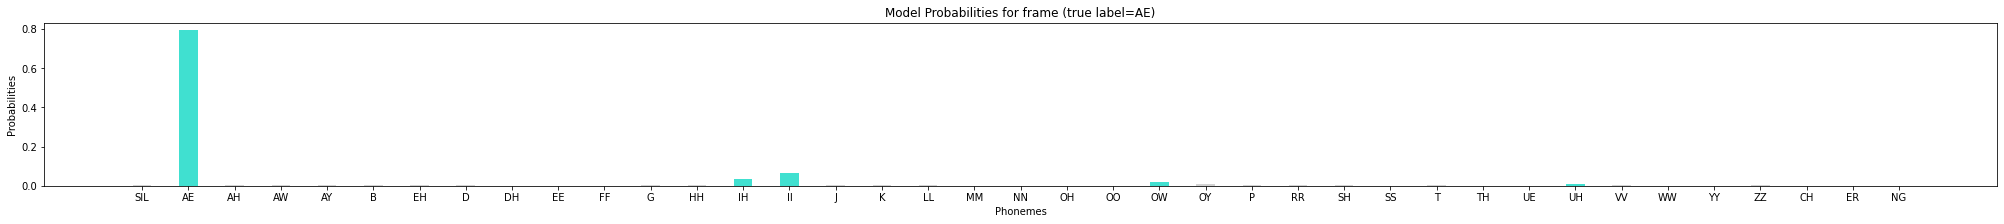

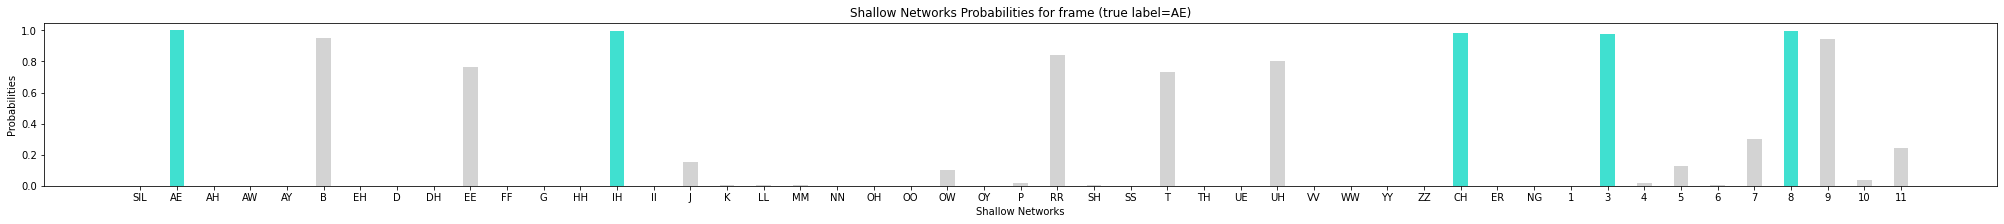

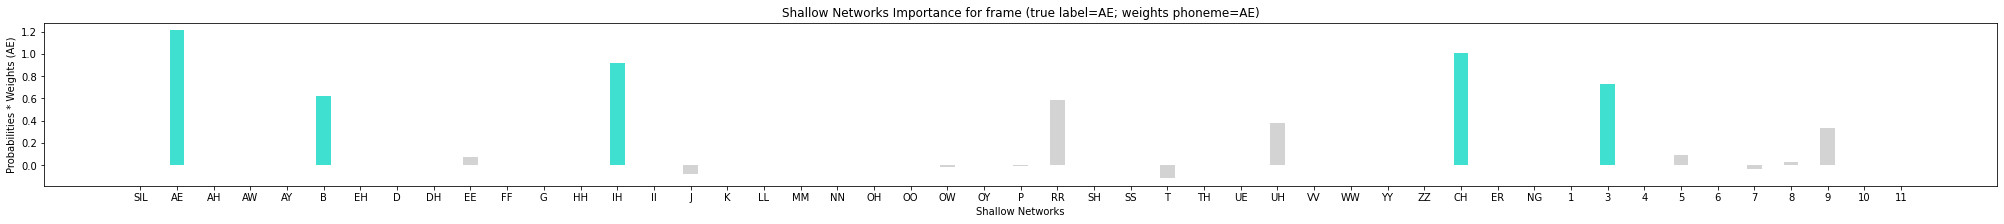

correctly classified as AE


In [749]:
classifier.interpret_phoneme_frame(phoneme_tag, phoneme_index, phoneme_features[0], phoneme_labels[0])

TESTING PHONEME 'SIL' (label=0)
features.shape: torch.Size([1, 40])
targets.shape: torch.Size([1, 1])
label assigned: 33
predicted_phoneme_tag: WW


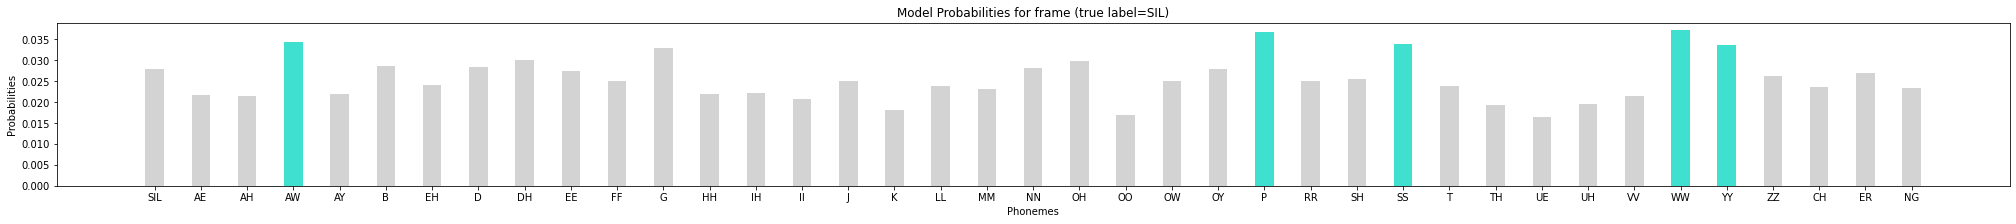

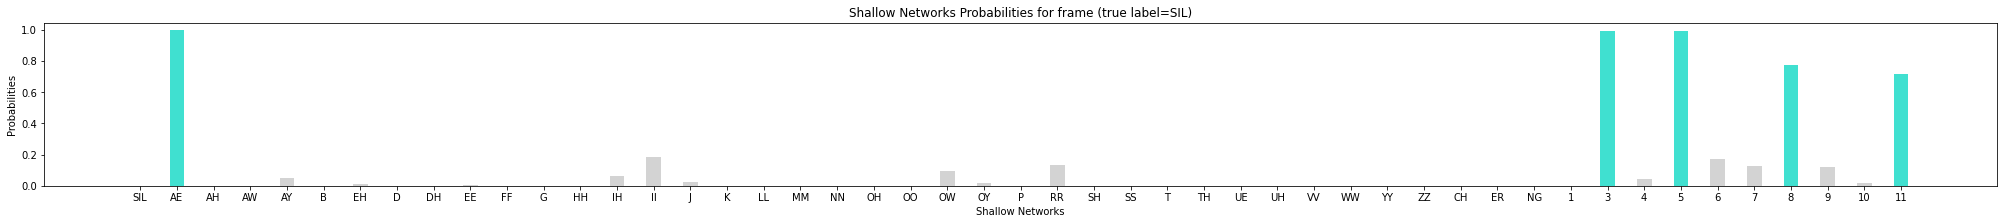

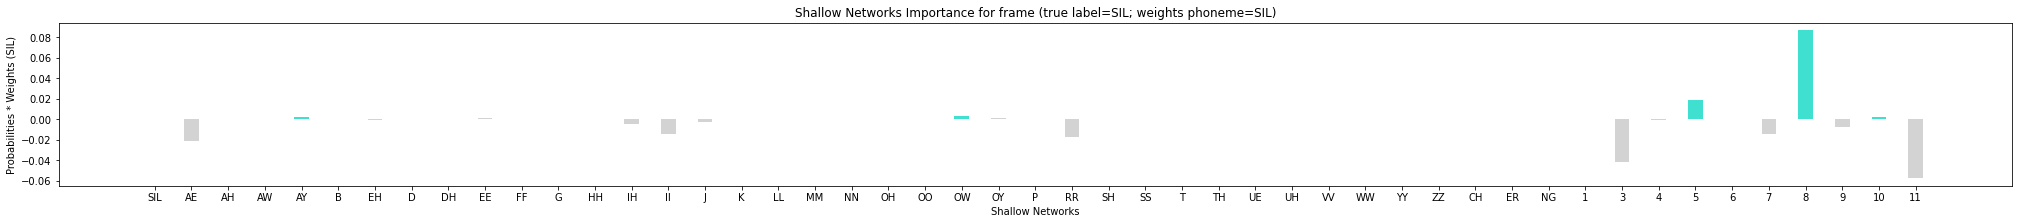

incorrectly classified as SIL (true=SIL)


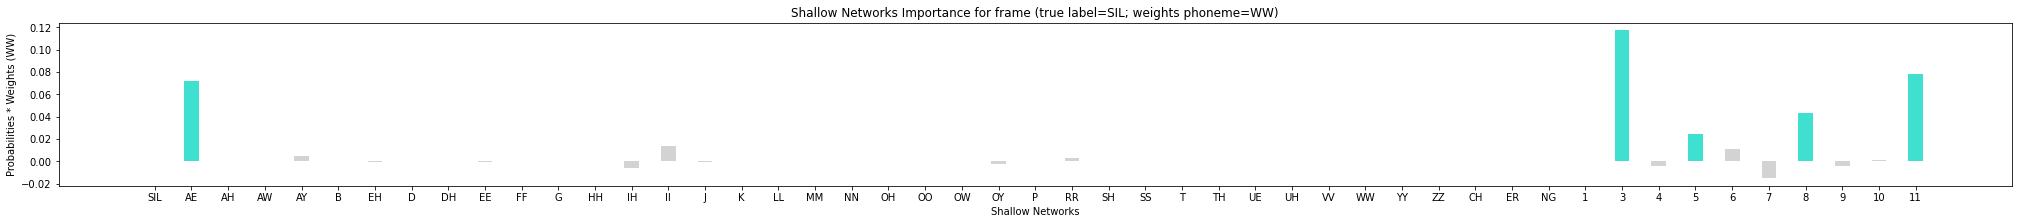


TESTING PHONEME 'AE' (label=1)
features.shape: torch.Size([1, 40])
targets.shape: torch.Size([1, 1])
label assigned: 33
predicted_phoneme_tag: WW


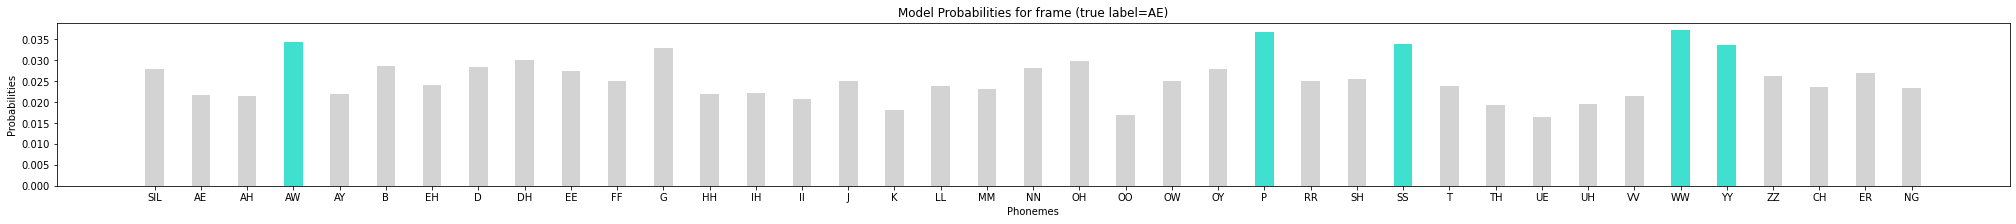

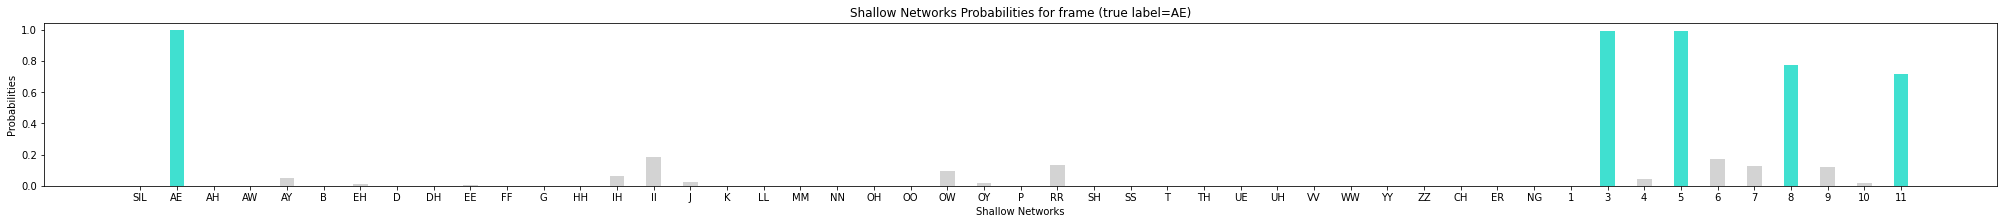

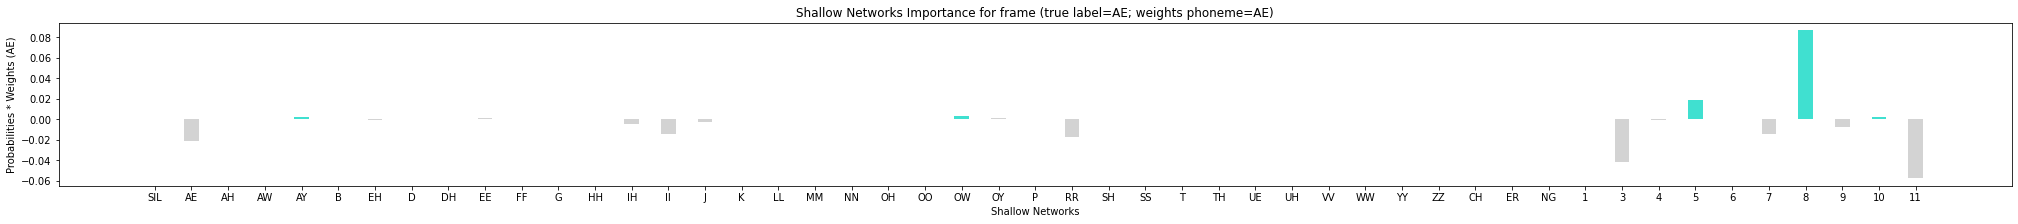

incorrectly classified as AE (true=AE)


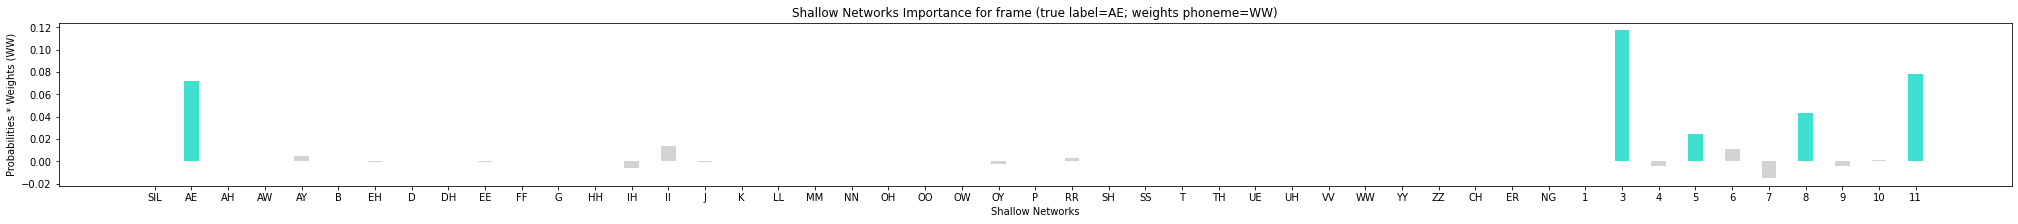


TESTING PHONEME 'AH' (label=2)
features.shape: torch.Size([1, 40])
targets.shape: torch.Size([1, 1])
label assigned: 33
predicted_phoneme_tag: WW


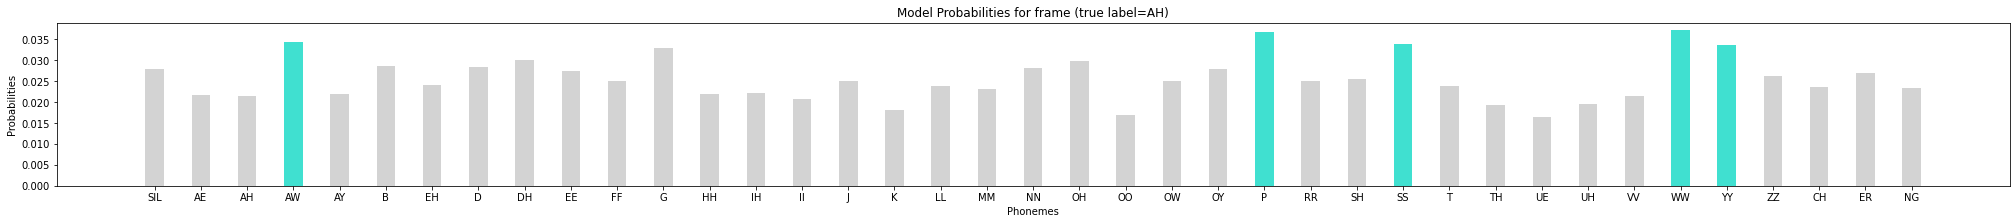

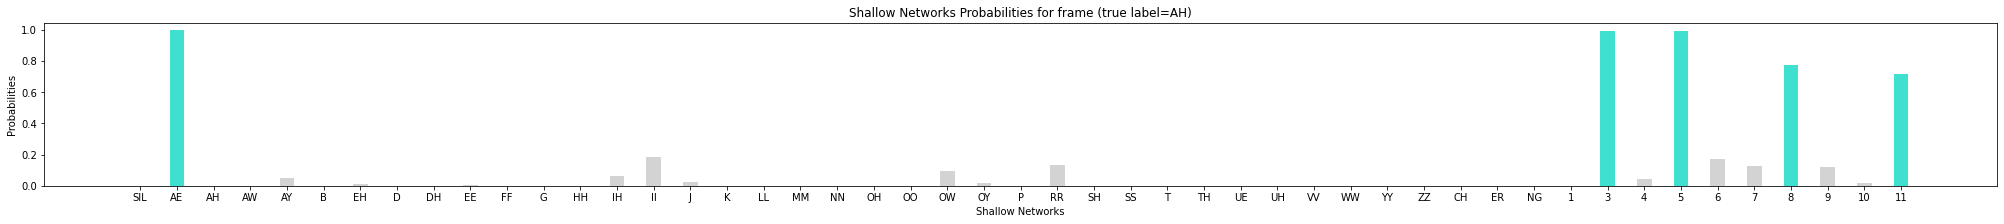

KeyboardInterrupt: ignored

In [735]:
classifier.plot_graphs_for_each_phoneme(dev_data)